# Color-color plots for LRG targets

The goal of this notebook is to compare the colors of LRG targets against those of the LRG *templates*.

In [1]:
import os
from time import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import fitsio
import seaborn as sns

from speclite import filters
from desitarget import desi_mask
from desisim.io import read_basis_templates

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
sns.set(style='white', font_scale=1.5, font='sans-serif', palette='Set2')
setcolors = sns.color_palette()

## Read the targets catalog

In [4]:
def flux2colors(cat):
    """Convert DECam/WISE fluxes to magnitudes and colors."""
    colors = dict()
    with warnings.catch_warnings(): # ignore missing fluxes (e.g., for QSOs)
        warnings.simplefilter('ignore')
        for ii, band in zip((1, 2, 4), ('g', 'r', 'z')):
            colors[band] = 22.5 - 2.5 * np.log10(cat['DECAM_FLUX'][..., ii].data)
        for ii, band in zip((0, 1), ('W1', 'W2')):
            colors[band] = 22.5 - 2.5 * np.log10(cat['WISE_FLUX'][..., ii].data)
    colors['gr'] = colors['g'] - colors['r']
    colors['rz'] = colors['r'] - colors['z']
    colors['rW1'] = colors['r'] - colors['W1']
    colors['W1W2'] = colors['W1'] - colors['W2']

    return colors

In [5]:
lrgfile = os.path.join( os.getenv('DESI_ROOT'), 'data', 'targets-dr3.1-EisDawLRG.fits' )

In [6]:
# Select just LRG targets.
print('Reading {}'.format(lrgfile))
cat = fitsio.read(lrgfile, ext=1, upper=True, columns=['DESI_TARGET'])
these = np.where( (cat['DESI_TARGET'] & desi_mask.LRG) != 0 )[0]
print('Number of LRG targets = {}'.format(len(these)))
cat = fitsio.read(lrgfile, ext=1, upper=True, rows=these)

Reading /Users/ioannis/research/projects/desi/data/targets-dr3.1-EisDawLRG.fits
Number of LRG targets = 2511248


In [7]:
data = flux2colors(cat)

## Read the templates and compute colors on a redshift grid.

In [8]:
filt = filters.load_filters('decam2014-g', 'decam2014-r', 'decam2014-z', 'wise2010-W1')

In [9]:
flux, wave, meta = read_basis_templates(objtype='LRG')
nt = len(meta)
print('Number of templates = {}'.format(nt))

INFO:io.py:625:read_basis_templates: Reading /Users/ioannis/research/projects/desi/spectro/templates/basis_templates/v2.3/lrg_templates_v1.3.fits
Number of templates = 144


In [10]:
zmin, zmax, dz = 0.0, 2.0, 0.1
nz = np.round( (zmax - zmin) / dz ).astype('i2')
print('Number of redshift points = {}'.format(nz))

cc = dict(
    redshift = np.linspace(0.0, 2.0, nz),
    gr = np.zeros( (nt, nz) ),
    rz = np.zeros( (nt, nz) ),
    rW1 = np.zeros( (nt, nz), )
)

Number of redshift points = 20


In [11]:
t0 = time()
for iz, red in enumerate(cc['redshift']):
    zwave = wave.astype('float') * (1 + red)
    phot = filt.get_ab_maggies(flux, zwave, mask_invalid=False)
    cc['gr'][:, iz] = -2.5 * np.log10( phot['decam2014-g'] / phot['decam2014-r'] )
    cc['rz'][:, iz] = -2.5 * np.log10( phot['decam2014-r'] / phot['decam2014-z'] )
    cc['rW1'][:, iz] = -2.5 * np.log10( phot['decam2014-r'] / phot['wise2010-W1'] )
print('Total time = {:.2f} sec.'.format(time() - t0))

Total time = 3.42 sec.


## Generate some plots

In [12]:
figsize = (8, 6)
grrange = (0.0, 3.0)
rzrange = (0.0, 2.5)
rW1range = (-1, 5)
mzrange = (17.5, 20.5)
ntspace = 5 # spacing between model curves

In [13]:
def rzz(pngfile=None):
    """r-z vs apparent magnitude z"""
    fig, ax = plt.subplots(figsize=figsize)
    hb = ax.hexbin(data['z'], data['rz'], bins='log', cmap='Blues_r', 
                   mincnt=100, extent=mzrange+rzrange)
    ax.set_xlabel('z')
    ax.set_ylabel('r - z')
    ax.set_xlim(mzrange)
    ax.set_ylim(rzrange)
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label(r'log$_{10}$ (Number of Galaxies per Bin)')
    if pngfile:
        fig.savefig(pngfile)

In [14]:
def grz(models=False, pngfile=None):
    fig, ax = plt.subplots(figsize=figsize)
    hb = ax.hexbin(data['rz'], data['gr'], bins='log', cmap='Blues_r', 
                   mincnt=100, extent=rzrange+grrange)
    ax.set_xlabel('r - z')
    ax.set_ylabel('g - r')
    ax.set_xlim(rzrange)
    ax.set_ylim(grrange)
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label(r'log$_{10}$ (Number of Galaxies per Bin)')
    if models:
        for tt in np.arange(0, nt, ntspace):
            ax.scatter(cc['rz'][tt, 0], cc['gr'][tt, 0], marker='o', 
                       facecolors='none', s=80, edgecolors='k',
                       linewidth=1)
            ax.plot(cc['rz'][tt, :], cc['gr'][tt, :], marker='s', 
                    markersize=5, ls='-', alpha=0.5)
        ax.text(0.1, 0.05, 'z=0', ha='left', va='bottom',
                transform=ax.transAxes, fontsize=14)
    if pngfile:
        fig.savefig(pngfile)

In [15]:
def rzW1(models=False, pngfile=None):
    fig, ax = plt.subplots(figsize=figsize)
    hb = ax.hexbin(data['rz'], data['rW1'], bins='log', cmap='Blues_r', 
                   mincnt=100, extent=rzrange+grrange)
    ax.set_xlabel('r - z')
    ax.set_ylabel('r - W1')
    ax.set_xlim(rzrange)
    ax.set_ylim(rW1range)
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label(r'log$_{10}$ (Number of Galaxies per Bin)')
    if models:
        for tt in np.arange(0, nt, ntspace):
            ax.scatter(cc['rz'][tt, 0], cc['rW1'][tt, 0], marker='o', 
                       facecolors='none', s=80, edgecolors='k',
                       linewidth=1)
            ax.plot(cc['rz'][tt, :], cc['rW1'][tt, :], marker='s', 
                    markersize=5, ls='-', alpha=0.5)
        ax.text(0.1, 0.05, 'z=0', ha='left', va='bottom',
                transform=ax.transAxes, fontsize=14)
    if pngfile:
        fig.savefig(pngfile)

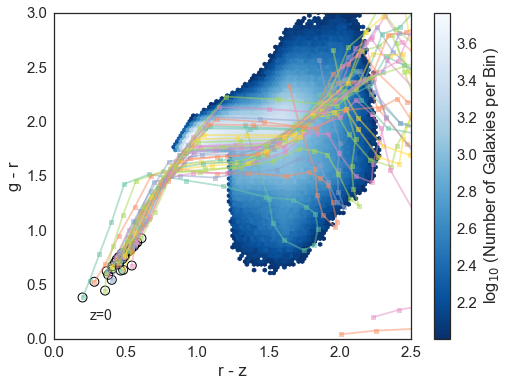

In [16]:
grz(models=True)

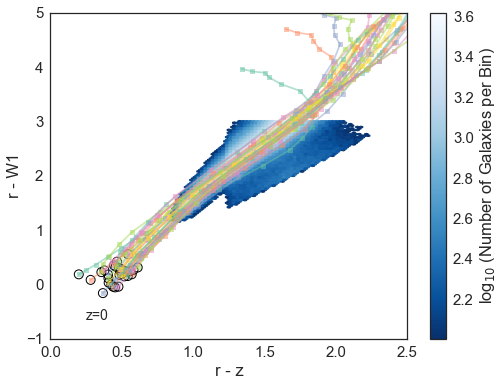

In [17]:
rzW1(models=True)

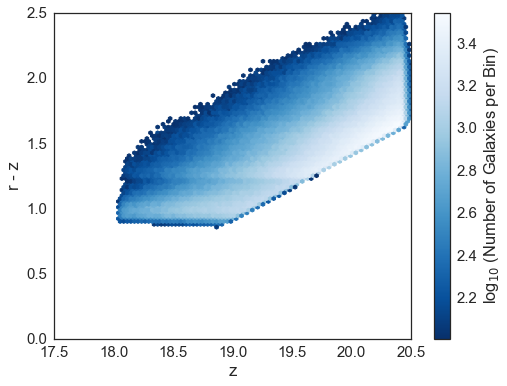

In [18]:
rzz()